In [1]:
# Read the Dataframe
import pandas as pd

df = pd.read_excel('../data/cleaned_v2.xlsx')
df = df.set_index('Department')

# Group by and display count for each category
# There are 11 categories of complaints
df.groupby(df.index).count()

,Description
Department,
Building Permission,2119
Drainage,2132
Electrical,4037
Encroachment,1470
Garbage,16932
Garden,1653
Health,2802
Property Tax,1491
Road,5510


In [2]:
# Make a dataset for training
# We are sampling 4000 entries per category, 
# thus minority classes are oversampled, ensuring that there is no imbalance in the dataset

# Q. What is the need to do this? 
# A. To resolve the bottleneck of having too few entries for some classes ~ 1400 
#    as well as too much for some classes ~16k. I have taken the number of samples as tunable,
#    and I arrived at the number 4000 just by hit and trial.

# STATE is used for producing replicable results
df_for_training = pd.DataFrame()
SAMPLES = 4000
STATE = 0

for i in list(set(df.index)):
    df_for_training = df_for_training.append(df.loc[i].sample(n=SAMPLES,random_state=STATE,replace=True))

df_for_training['class_label'] = df_for_training.index.factorize()[0]

In [3]:
df_for_training

,Description,class_label
Department,,
Garden,A big tree in adjacent Madhav Park Society has...,0
Garden,A large trunk of a tree in Pingle Chowk on Lan...,0
Garden,Today on 17.4. 17 a big tree near Lunkad Green...,0
Garden,Nagarikana Yeta Jata adthala yet aahe. zhad pu...,0
Garden,Due to heavy rain the branches of the Road Sid...,0
...,...,...
Property Tax,I am requesting for discount in property tax f...,10
Property Tax,till now the bills were showing name as KIRAN ...,10
Property Tax,The same property is registered on p/4/4 / 3 1...,10


In [25]:
# Since the classes are now numbered, I am storing this in a mapper.
import json

mapper_df = df_for_training[['class_label']].reset_index().groupby('Department').mean()
mapper = mapper_df.to_dict()['class_label']
mapper = dict([(v, k) for k, v in mapper.items()])

with open("../data/mapper.json", "w") as outfile:  
    json.dump(mapper, outfile) 

In [5]:
# importing libraries for the model

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


import re
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manpreet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Initializing the stemmer, stopwords and the vectorizer

stemmer = PorterStemmer()
words = stopwords.words("english")
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True)


In [7]:
# Creating the input set by renaming columns and shuffling

X = df_for_training.copy() # Deep copy
X.columns = ['text','label']
X.index.name = None
X = X.reset_index()
X = X[['text','label']]
X = X.sample(frac=1)

In [8]:
X

,text,label
16437,Sweeping not done,4
36949,Garbage is burnt in open air and all residents...,9
6110,In sococeity /3 stray dogs r living n biting....,1
7998,Namud kelelya pattyavar dog che praman khup mo...,1
23676,There are halkers or beggers living g under th...,5
...,...,...
13804,This is for PMC Big Bosses: Here are the statu...,3
39016,NAMUD KELELYA PATTYVAR KHUP DAS ZALE AAHET FAV...,9
38018,Three to four people in society have got dengu...,9
38458,pashan lake is full of Jalparni. Need attention.,9


In [9]:
# Creating the train-test split 
X['cleaned'] = X['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

x = X['cleaned']
y = X['label']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

Y_test = np.array(y_test)

In [10]:
# Initializing the models
models = {
            'RandomForest' : RandomForestClassifier(n_estimators=400,n_jobs=4),
            'LinearSVC' : LinearSVC(),
            'MultinomialNB' : MultinomialNB(),
            'LogisticRegression' : LogisticRegression(max_iter=200)
         }

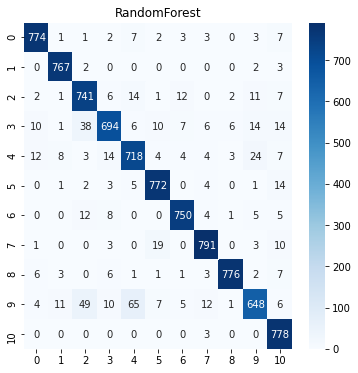

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       803
           1       0.97      0.99      0.98       774
           2       0.87      0.93      0.90       797
           3       0.93      0.86      0.89       806
           4       0.88      0.90      0.89       801
           5       0.95      0.96      0.95       802
           6       0.96      0.96      0.96       785
           7       0.95      0.96      0.95       827
           8       0.98      0.96      0.97       806
           9       0.91      0.79      0.85       818
          10       0.91      1.00      0.95       781

    accuracy                           0.93      8800
   macro avg       0.93      0.93      0.93      8800
weighted avg       0.93      0.93      0.93      8800



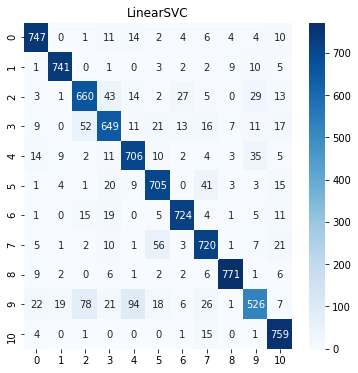

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       803
           1       0.95      0.96      0.96       774
           2       0.81      0.83      0.82       797
           3       0.82      0.81      0.81       806
           4       0.83      0.88      0.86       801
           5       0.86      0.88      0.87       802
           6       0.92      0.92      0.92       785
           7       0.85      0.87      0.86       827
           8       0.96      0.96      0.96       806
           9       0.83      0.64      0.73       818
          10       0.87      0.97      0.92       781

    accuracy                           0.88      8800
   macro avg       0.88      0.88      0.87      8800
weighted avg       0.88      0.88      0.87      8800



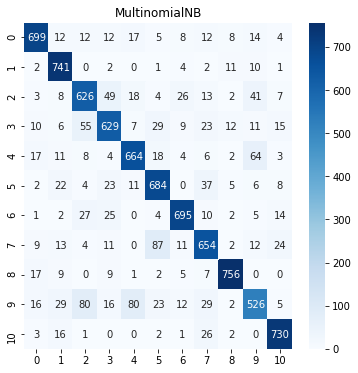

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       803
           1       0.85      0.96      0.90       774
           2       0.77      0.79      0.78       797
           3       0.81      0.78      0.79       806
           4       0.83      0.83      0.83       801
           5       0.80      0.85      0.82       802
           6       0.90      0.89      0.89       785
           7       0.80      0.79      0.79       827
           8       0.94      0.94      0.94       806
           9       0.76      0.64      0.70       818
          10       0.90      0.93      0.92       781

    accuracy                           0.84      8800
   macro avg       0.84      0.84      0.84      8800
weighted avg       0.84      0.84      0.84      8800



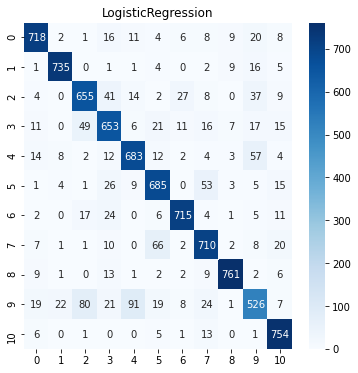

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       803
           1       0.95      0.95      0.95       774
           2       0.81      0.82      0.82       797
           3       0.80      0.81      0.80       806
           4       0.84      0.85      0.84       801
           5       0.83      0.85      0.84       802
           6       0.92      0.91      0.92       785
           7       0.83      0.86      0.85       827
           8       0.96      0.94      0.95       806
           9       0.76      0.64      0.70       818
          10       0.88      0.97      0.92       781

    accuracy                           0.86      8800
   macro avg       0.86      0.86      0.86      8800
weighted avg       0.86      0.86      0.86      8800



In [11]:
accuracies = {}
for model_name in list(models.keys()):
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

    model = pipeline.fit(X_train, y_train)
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
        
    
    plt.figure(figsize=(6,6))
    plt.title(model_name)
    sns.heatmap(confusion_matrix(Y_test, model.predict(X_test)),annot=True,fmt='',cmap='Blues')
    plt.show()
    
    accuracies[model_name] = "{:.2f}".format(model.score(X_test, Y_test) * 100)
    print(classification_report(Y_test, model.predict(X_test)))

In [12]:
accuracies

{'RandomForest': '93.28',
 'LinearSVC': '87.59',
 'MultinomialNB': '84.14',
 'LogisticRegression': '86.31'}

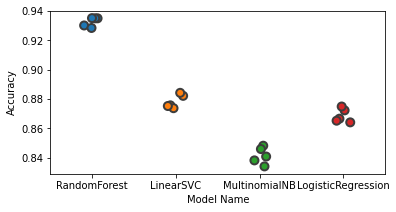

In [13]:
# Performing 5-fold cross validation for better selection of the model best suited

pipelines = {}
for model_name in list(models.keys()):
    pipelines[model_name] = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model_name, model in pipelines.items():
    accuracies = cross_val_score(model, x, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Model Name', 'fold_idx', 'Accuracy'])

plt.figure(figsize=(6,3))
sns.stripplot(x='Model Name', y='Accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [14]:
with open('RandomForest.pkl','rb') as file:
    model = pickle.load(file)

In [15]:
text = ['garbage not cleared near PEC campus']
query = [" ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower() for x in text]

mapper[model.predict(query)[0]]

'Garbage'